# Create 2D Seismic Patches from Seismic Volume

In [1]:
import numpy as np
import segyio
import random
import string
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path 
from ipywidgets import widgets, interact, ToggleButtons, IntSlider


def createPatches(filename:str|Path, image_name:str, type:str, patch_size:slice):#, cmap:str, preview:bool):
    

    def segy2numpy(filename:str|Path) -> np.array:
        with segyio.open(filename) as f:
            return segyio.tools.cube(f).transpose(2, 1, 0)
    

    def extractAlgo(image_name:str, patch_size:tuple):

        start = 0
        step = patch_size[0]

        if Path(f'data/{type}/images').exists():
            pass
        else:
            Path(f'data/{type}/images').mkdir()
            
        image = np.array(Image.open('data/'+image_name+'.png'))

        for row in range(start, image.shape[0], step):
            if ((row+step) > image.shape[0]):
                break
            for column in range(start, image.shape[1], step):
                if ((column+step) > image.shape[1]):
                    break
                image_arr = image[row:row+step, column:column+step, :]
                patchname = ''.join(random.choices(
                    string.ascii_lowercase + string.digits, k=20)) + '.png'

                image_patch = Image.fromarray(image_arr[:, :, :3])
                    
                image_patch.save(f'data/{type}/images/'+patchname)

    # Interactive display   
    seismic = segy2numpy(filename)
    
    max = seismic.shape[2] - 1
    cmap = ['PuOr_r', 'gray', 'cubehelix', 'cubehelix', 'jet', 'plasma', 'inferno', 'seismic_r']
    slice = ToggleButtons(description='Slice options', button_style='primary', options=['IL', 'XL', 'ZL'])
    id = IntSlider(description='Slice number', value=0, min=0, max=max, step=10)
    cmap = ToggleButtons(description='Colormaps', button_style='primary', options=np.unique(cmap))
    preview = ToggleButtons(description='Preview options', button_style='primary', options=[True, False])
    
    vmin = widgets.FloatSlider(value=np.min(seismic), min=np.min(seismic), 
                             max=np.amax(seismic))
    
    vmax = widgets.FloatSlider(value=np.max(seismic), min=np.min(seismic), 
                             max=np.max(seismic))

    @interact
    def preview_extract(slice=slice, id=id, cmap=cmap, preview=preview, vmin=vmin, vmax=vmax):

        if preview:
            
            plt.figure(figsize=(50, 10))

            if slice == 'IL':
                plt.imshow(seismic[:, :, id], cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bicubic')
                
            elif slice == 'XL':
                plt.imshow(seismic[:, id, :], cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bicubic')

            elif slice =='ZL':
                plt.imshow(seismic[id, :, :], cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bicubic')
            
            plt.axis('off')
            plt.savefig('data/'+image_name+'.png', bbox_inches='tight', pad_inches=0.)

        else:
            print('Image Patches extraction started...')
            print('*'*30)

            extractAlgo(image_name, patch_size=patch_size)

            print('*'*30)
            print('Image Patches extraction completed...')


In [2]:
# from create_patches import createPatches
createPatches(filename='data/F3.segy', image_name='image', type='test', patch_size=(128, 128))


/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(ToggleButtons(button_style='primary', description='Slice options', options=('IL', 'XL', …

# Seismic Attributes for creating masks

In [35]:
def attrComp(data, attri_type:str, threshold:int|float, kernel:tuple, noise:str):
    
    '''
    
    This module helps to apply noise reduction algorithm on 2D seismic before computing seismic attributes
    for creating seismic masks
    '''
    import sys
    sys.path.append('./attributes')
    
    from attributes.CompleTrace import ComplexAttributes
    from attributes.SignalProcess import SignalProcess
    from attributes.NoiseReduction import NoiseReduction

    import numpy as np
    
    def makeDask(darray, kernel, attri_type, noise):

        def noise_reduction(darray, noise):

            #apply noise reduction algo
            n = NoiseReduction()
            narray, _ = NoiseReduction.create_array(n, darray, kernel=None, preview=None)
            narray = narray.T.rechunk('auto')

            if noise == 'gaussian':
                nresult = NoiseReduction.gaussian(n, narray, preview=None)
                nresult = nresult.T

            if noise == 'median':
                nresult = NoiseReduction.median(n, narray, preview=None)
                nresult = nresult.T

            if noise == 'convolution':
                nresult = NoiseReduction.convolution(n, narray, preview=None)
                nresult = nresult.T

            return nresult
        
        #denoised seismic array
        narray = noise_reduction(darray, noise)
        
        #make dask array for attribute computation
        if attri_type == 'rms' or attri_type == 'reflin' or attri_type == 'timegain' or attri_type == 'fder'\
            or attri_type == 'sder' or attri_type == 'gradmag':
            
            x = SignalProcess()
            darray, chunks_init = SignalProcess.create_array(x, narray, kernel, preview=None)
            darray = darray.T
                
            return (x, darray, narray)
        
        if attri_type == 'sweetness' or attri_type == 'infreq' or attri_type == 'enve' or attri_type == 'inphase'\
            or attri_type == 'cosphase' or attri_type == 'ampcontrast' or attri_type == 'ampacc' or \
            attri_type == 'inband' or attri_type == 'domfreq' or attri_type == 'apolar' or attri_type == 'resamp'\
            or attri_type == 'resfreq' or attri_type == 'resphase':

            x = ComplexAttributes()
            darray, chunks_init = ComplexAttributes.create_array(x, narray, kernel, preview=None)
            darray = darray.T
            
            return (x, darray, narray)
    
    def compute(x, darray, attri_type):
        
        '''
        Computes the seismic attribute
        '''

        if attri_type == 'reflin':
            result = SignalProcess.reflection_intensity(x, darray, preview=None)
            return result

        if attri_type == 'enve':
            result = ComplexAttributes.envelope(x, darray, preview=None)
            return result
        
        if attri_type == 'sweetness':
            result = ComplexAttributes.sweetness(x, darray, preview=None)
            return result
        
        if attri_type == 'infreq':
            result = ComplexAttributes.instantaneous_frequency(x, darray, preview=None)
            return result
        
        if attri_type == 'fder':
            result = SignalProcess.first_derivative(x, darray, axis=-1, preview=None)
            return result
      
        if attri_type == 'sder':
            result = SignalProcess.second_derivative(x, darray, axis=-1, preview=None)
            return result
        
        if attri_type == 'rms':
            result = SignalProcess.rms(x, darray, kernel=(1, 1, 9), preview=None)
            return result

        if attri_type == 'timegain':
            result = SignalProcess.time_gain(x, darray, preview=None)
            return result
        
        if attri_type == 'gradmag':
            result = SignalProcess.gradient_magnitude(x, darray, sigmas=(1,1,1), preview=None)
            return result
        
        if attri_type == 'inphase':
            result = ComplexAttributes.instantaneous_phase(x, darray, preview=None)   
            return result

        if attri_type == 'cosphase':
            result = ComplexAttributes.cosine_instantaneous_phase(x, darray, preview=None)   
            return result

        if attri_type == 'ampcontrast':
            result = ComplexAttributes.relative_amplitude_change(x, darray, preview=None)
            return result

        if attri_type == 'ampacc':
            result = ComplexAttributes.amplitude_acceleration(x, darray, preview=None)
            return result
        
        if attri_type == 'inband':
            result = ComplexAttributes.instantaneous_bandwidth(x, darray, preview=None)
            return result

        if attri_type == 'domfreq':
            result = ComplexAttributes.dominant_frequency(x, darray, sample_rate=4, preview=None)
            return result

        if attri_type == 'apolar':
            result = ComplexAttributes.apparent_polarity(x, darray, preview=None)
            return result

        if attri_type == 'resamp':
            result = ComplexAttributes.response_amplitude(x, darray, preview=None)
            return result

        if attri_type == 'resfreq':
            result = ComplexAttributes.response_frequency(x, darray, sample_rate=4, preview=None)
            return result

        if attri_type == 'resphase':
            result = ComplexAttributes.response_phase(x, darray, preview=None)
            return result
        

    #First option to generate seismic mask is to cluster into two classes
    # def kMeans(attri, nclusters=2):
    #     '''
    #     To cluster attribute array into horizon/non-horizon  
    #     '''
    #     from sklearn.cluster import MiniBatchKMeans

    #     kmeans = MiniBatchKMeans(n_clusters=nclusters, random_state=0).fit_predict(attri.reshape((-1, 1)))

    #     k_pred = kmeans.reshape(*attri.shape)
        
    #     return k_pred

    #Second option is to set a threshold value to cluster the image
    def extMask(cube, threshold):
    
        '''
        Extract salt/horizon mask from an attribute cube
        '''
        # #apply PCA to reduce dimensionality
        # from sklearn.decomposition import KernelPCA
        # cube = KernelPCA(n_components=2, kernel='rbf').fit_transform(cube.squeeze())
        geobody = np.where(cube < threshold, 255, 0).astype('int32') #depends on slice type

        return geobody
        
    '''
    Main Program
    
    '''
    ori_image = data.copy()
    darray = data

    #apply attribute
    x, darray, noise_red = makeDask(darray, kernel=kernel, 
                                    attri_type=attri_type, noise=noise)
    darray = darray.rechunk('auto')
    result = compute(x, darray, attri_type=attri_type)

    #extract mask
    attr = result.T #convert dask array attribute to numpy array
    mask = extMask(cube=attr, threshold=threshold) #generate horizon masks
    
    #return result
    return ori_image, noise_red, attr, mask

In [48]:
def seismicViewer(cube, cube_name):
    '''
    
    helps to preview seismic attribute results,  before extracting the mask patches 
    '''
    from ipywidgets import widgets, interact
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
                                      
    data=cube
    image=cube

    attributes = ['sweetness', 'infreq', 'reflin', 'rms', 'timegain', 'enve', 'fder', 'sder',
                  'gradmag', 'inphase', 'cosphase', 'ampcontrast', 'ampacc', 'inband', 'domfreq',
                  'resamp', 'apolar', 'resfreq', 'resphase']

    cmap = ['PuOr_r', 'gray', 'cubehelix', 'jet', 'plasma', 'inferno', 'seismic_r', 'gist_rainbow', 'Accent']

    noise = ['gaussian', 'median', 'convolution']
    
    # Interactive plotting
    attri_type = widgets.Dropdown(description='Attribute Type', options=attributes)
    
    cmap_button = widgets.Dropdown(description='Colormaps', options=np.unique(cmap))

    noise = widgets.Dropdown(description='Noise Reduction', options=noise)

    vmin = widgets.FloatSlider(value=np.amin(data), min=np.amin(data), 
                             max=np.amax(data))
    
    vmax = widgets.FloatSlider(value=np.amax(data), min=np.amin(data), 
                             max=np.amax(data))
    
    threshold = widgets.FloatSlider(description='Threshold', value=np.amax(data), 
                                  min=np.amin(data), max=np.amax(data))
    
    kernel = widgets.Dropdown(description='Kernel', #kernel may chape the shape of the resulting mask, best to leave at None :)
                              options=[None, 
                                       (10, 9, 1),
                                        (1, 1, 3),
                                        (3, 3, 1),
                                        (1, 1, 1)])
    
    @interact   
    def f(attri_type=attri_type, vmin=vmin, vmax=vmax, kernel=kernel, cmap=cmap_button, threshold=threshold, noise=noise):  

        ori_image, noise_red, attr, mask = attrComp(data=image, 
                                                    threshold=threshold, 
                                                    attri_type=attri_type,
                                                    kernel=kernel,
                                                    noise=noise)
        print(f'Image shape = {ori_image.shape}')
        print(f'Mask shape = {mask.shape}')
        print(f'Attribute shape = {attr.shape}')

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 10))        
        
        fig.suptitle(f'Horizon Tracking of 2D Seismic - {cube_name}', size=60)

        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="2.5%", pad=0.1)
        ax1.set_title('Original Seismic Image', size=20)
        im1=ax1.imshow(ori_image, cmap='RdBu')
        plt.colorbar(im1, cax=cax)
        
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="2.5%", pad=0.1)
        ax2.set_title(f'Denoised Seismic Image\n{noise.upper()}', size=20)
        im2=ax2.imshow(noise_red.squeeze(), cmap='gray')
        plt.colorbar(im2, cax=cax)
        
        divider = make_axes_locatable(ax3)
        cax = divider.append_axes("right", size="2.5%", pad=0.1)
        ax3.set_title(f'Seismic Attribute\n{attri_type.upper()}', size=20)
        im3 = ax3.imshow(attr.squeeze(), cmap=cmap, vmin=vmin, vmax=vmax, interpolation='bicubic')
        plt.colorbar(im3, cax=cax)
        
        divider = make_axes_locatable(ax4)
        cax = divider.append_axes("right", size="2.5%", pad=0.1)
        ax4.set_title(f'Mask\nThresh Value={threshold}', size=20)
        im4 = ax4.imshow(mask.squeeze(), cmap='gray')
        plt.colorbar(im4, cax=cax)

        plt.show()
        print('*'*120)

In [49]:
from pathlib import Path

class ExtractPatches(object):
    
    def __init__(self, imgs_path:Path,  attribute_type:str, threshold=1, kernel=None, noise='gaussian'):
        
        from pathlib import Path
        
        self.img_paths = Path(imgs_path)
        self.attribute_type = attribute_type
        self.threshold = threshold
        self.kernel = kernel
        self.noise = noise
    
    def __call__(self, preview, idx=None):
        return self.extractPatches(preview=preview, idx=idx)
    
    def get_image_paths(self):
        
        from pandas import read_csv, DataFrame
        from os import listdir, path
        
        image_paths = [path.join(self.img_paths,'images', i) for i in listdir(self.img_paths/'images')]
        image_names = [i[:-4] for i in listdir(self.img_paths/'images')]
        
        mask_names = image_names
        
        data = DataFrame()
        data['images'] = image_paths
        
        return data, mask_names

    def read_images(self):
        
        from torchvision import io

        image_df, mask_names = self.get_image_paths()
        
        images = list()
        for idx in image_df.images:
            image = io.read_image(str(idx), mode=io.ImageReadMode.GRAY).permute(1, 2, 0).numpy()
            images.append(image)
        
        return images, mask_names
    
    def run_attribute(self):
        
        images, mask_names = self.read_images()
        
        masks = list()
        attris = list()
        ori_images = list()
        noise_reds = list()
        
        for img in images:
            ori_image, noise_red, attr, mask = attrComp(data=img,
                                                        attri_type=self.attribute_type,
                                                        threshold=self.threshold,
                                                        kernel=self.kernel,
                                                        noise=self.noise)
            
            masks.append(mask)
            attris.append(attr)
            ori_images.append(ori_image)
            noise_reds.append(noise_red)

        return ori_images, noise_reds, attris, masks, mask_names
    
    def extractPatches(self, preview, idx=None):
        
        import numpy as np
        from numpngw import write_png
        from tqdm.auto import tqdm
        from PIL import Image
        
        ROOT = self.img_paths
        images, noise_reds, attris, tmasks, mask_names = self.run_attribute()
        
        if preview:
            assert idx != None, 'idx must be supplied'
            for _, i in enumerate(images[:idx]):
                
                seismicViewer(i, mask_names[_])
        else:
            try:

                masks = 'masks'

                if Path(ROOT/masks).exists():
                    print(f'{masks} directory already exists! Overwriting....')
                else:
                    print(f'Creating {masks} directory...')
                    Path(ROOT/masks).mkdir()
                    
            except:
                raise Exception('Error creating directories!')

            print('='*60)
            print('     Masks extraction started!...')
            print()
            
            for mask, maskname in tqdm(zip(tmasks, mask_names)):

                shape = (mask.shape[0], mask.shape[1]*mask.shape[2])
                
                write_png(f'{str(ROOT)}/{masks}/{maskname}'+'.png', 
                          mask.reshape(shape).astype(np.uint8), bitdepth=1)          
            
            print('     Masks extraction completed...!')
            print('='*60)


In [52]:
from pathlib import Path

path = Path(r"data/test")

extract = ExtractPatches(path, attribute_type='enve', threshold=0, kernel=None)

In [53]:
extract(preview=True, idx=10)

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

In [45]:
extract(preview=False)

masks directory already exists! Overwriting....
     Masks extraction started!...



0it [00:00, ?it/s]

     Masks extraction completed...!


In [42]:
from torchvision import io
img = io.read_image('data/image.png',
                     mode=io.ImageReadMode.GRAY).permute(1, 2, 0).numpy()

seismicViewer(img, 'Inline 70')

/home/mayorofgeology/.local/lib/python3.10/site-packages/traitlets/traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='Attribute Type', options=('sweetness', 'infreq', 'reflin', 'rms', …

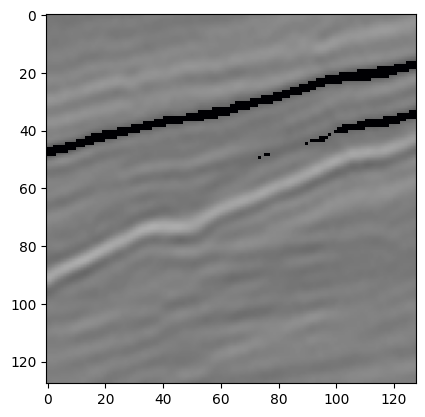

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
mask = np.array(Image.open('data/test/masks/wzmiuvv4j5tyx9u2w21h.png'))
image = np.array(Image.open('data/test/images/wzmiuvv4j5tyx9u2w21h.png'))

mask = np.ma.masked_where(mask==0, mask)
plt.imshow(image)
plt.imshow(mask, cmap='inferno', alpha=1.)